In [307]:
import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import RNNT
from IPython.display import Audio
import librosa
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

In [308]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(8)
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)
    
def conv2wav_torch(audio_dir, resample):
    mp3 = AudioSegment.from_mp3(audio_dir)
    wav = mp3.export(f'{audio_dir[:-4]}.wav', format="wav")
    waves, sr = torchaudio.load(f'{audio_dir[:-4]}.wav')
    waves = F.resample(waves, orig_freq=sr, new_freq=resample)
    return waves, resample

def vad_torch(waves, buff_size, threshold, display_info=False):
    mono_signal = waves[0].numpy()
    total_sig   = int(mono_signal.shape[0]/buff_size)
    signal      = []
    for i in range(total_sig):
        sig = mono_signal[i*buff_size:(i+1)*buff_size]
        rms = math.sqrt(np.square(sig).mean())
        if(rms > threshold):
            signal = np.append(signal,sig)
    signal = signal.astype('float')
    if (display_info):
        print("Number of total signal (signal_arr/buff_size):", total_sig)
        print("Signal data type:", signal.dtype)
        print(f"Signal shape: ({signal.shape})")
    return torch.tensor([signal])

In [309]:
waves, sr = conv2wav_torch('./cv_test.mp3', 8000)
signal_vad = vad_torch(waves, 1000, 0.012)

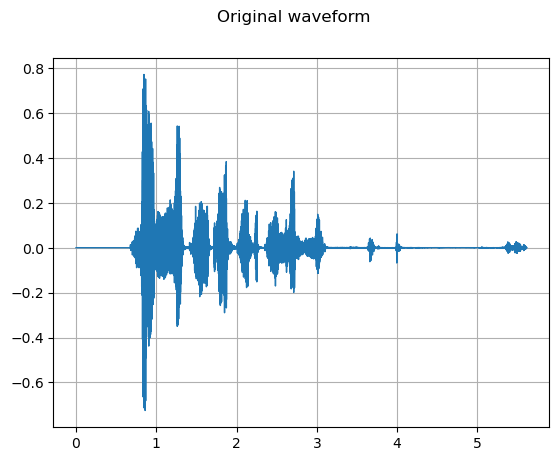

In [310]:
plot_waveform(waves, sr, title="Original waveform")
Audio(sig.numpy(), rate=48000) #48000 is the default sample rate from audio

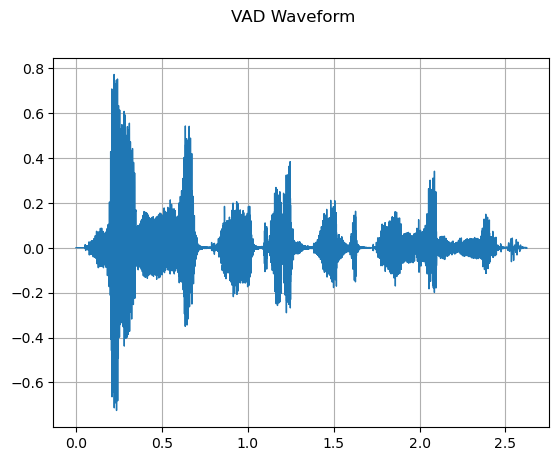

In [311]:
plot_waveform(signal_vad, sr, title="VAD Waveform")
Audio(signal_vad.numpy(), rate=sr)

In [312]:
speech_waveform = torchaudio.load('cv_test.wav')[0] # Sebelum dilakukan VAD

In [313]:
print(speech_waveform.shape)
print(signal_vad.shape) # Setelah dilakukan VAD, ukuran tensornya berubah

torch.Size([1, 269568])
torch.Size([1, 21000])


In [314]:
n_fft = 1024
win_length = None
hop_length = 128
n_mels = 64
n_mfcc = 64

mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(signal_vad.type(torch.float))

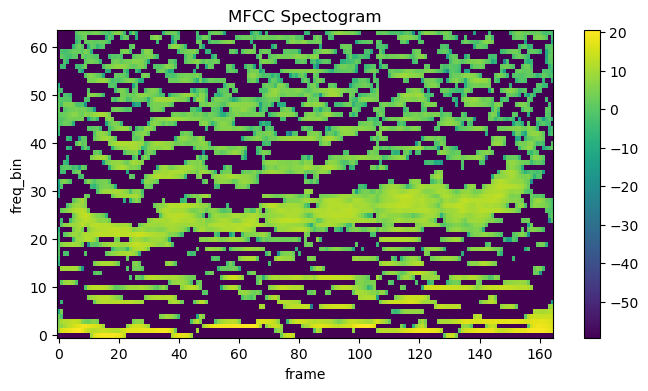

In [315]:
plot_spectrogram(mfcc[0], title="MFCC Spectogram")

In [316]:
mfcc[0].shape

torch.Size([64, 165])